# SFD-CNN-TL

In [4]:
import os, sys, cv2
import pandas as pd
import numpy as np
import plotly.plotly as py
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import matplotlib.image as im
import skimage.morphology as morphology
import classifier
import imageio
from skimage.filters import gaussian
from skimage import measure
from matplotlib.colors import LinearSegmentedColormap

%matplotlib inline
import mpld3
mpld3.enable_notebook()

np.random.seed(1337)

## First generate your slice and export as csv file in opendtect
- Survey -> Export -> Seismic -> Simple File -> 3D
- Select "1 Original Seismics" as Input Cube
- Choose a volume subsection, (our was inline:244~244, crossline:300~1250, z-slice:0~1848) to get inline #244
- **Output a position for every trace:** no
- **Put sampling info in file start:** no
- **File type:** ASCII
- **Output file:** slice.csv

## Format csv file

In [ ]:
# Gaussian smoothing with default std 1.5
# https://stackoverflow.com/a/45020378
def myGaussSmooth( data, std=1.5):
    return gaussian(data,sigma=std,truncate=2)

In [ ]:
#Clipping 
def clip(data,min=-6000,max=6000):
    data[data>max] = max
    data[data<min] = min
    return data

In [ ]:
# Normalizes values of a matrix between -1 and 1
def myNormalization(data):
    max_val = np.max(data)
    min_val = np.min(data)
    
    return  2 * (data[:,:] - min_val) / (max_val - min_val) - 1

In [ ]:
# Set configurations for format subvolume
data_file = 'data/f3_inl_244.csv'
min_inl = 244
max_inl = 244
min_crl = 300
max_crl = 1250

output_dir = 'data/formatted/'
if not os.path.exists(output_dir):
    os.makedirs(output_dir) 

# Read and format files
raw_data = np.genfromtxt(data_file, delimiter='\t')

nb_crosslines = max_crl - min_crl + 1
nb_sections = raw_data.shape[0]/nb_crosslines

for k in range(int(nb_sections)):
    # Output name
    inl_nb = int(min_inl + k);
    name = 'inl'+str(inl_nb)+'_sc_formatted.csv'

    # Read
    section = raw_data[k*nb_crosslines : (k+1)*nb_crosslines, : ]
    section = np.transpose(section)
    
    # Smooth
    section = myGaussSmooth(section)

    # Clip
    section = clip(section)

    # Normalize between -1 and 1 
    section = myNormalization(section)

    # Write
    np.savetxt(output_dir + name, section, delimiter=" ")
    
    # Visualize
    plt.imshow(section, cmap="gray")

In [ ]:
# Define sections type
types=['inline','crossline','z-slice','section_coords']
section_type = 'inline'

# read and convert coords for clipping to ROI
if(section_type == "inline"):
    x1 = 359 # crl init
    x2 = 549 # crl end
    y1 = 1400 # z init
    y2 = 1848 # z end
    init_data_x = 300 # cube data crl init
    z_step = 4 # z_step
    
    x1Idx = x1 - init_data_x
    x2Idx = x2 - init_data_x
    y1Idx = int(y1 / z_step)
    y2Idx = int(y2 / z_step)
    ## TODO : zline and crl sections

# Set directories
input_dir = 'data/formatted/'
output_dir = 'output/sections_regions/'
if not os.path.exists(output_dir):
    os.makedirs(output_dir) 


# cut regions
files = os.listdir(input_dir)
for i in range(0, len(files)):
    # open section
    filename = files[i]
    formatted_section = np.genfromtxt(input_dir + filename, delimiter=' ')

    # extraction        
    piece = formatted_section[y1Idx:y2Idx,x1Idx:x2Idx]

    # save
    out_filename = filename.split('.')[0] + "_region_(" + str(x1) + "." + str(y1) + ")(" + str(x2) + "." + str(y2) + ").csv"
    np.savetxt(output_dir + out_filename, piece, delimiter=" ")
    
    # Visualize
    plt.figure()
    plt.imshow(piece, cmap="gray", vmin=-1, vmax=1)

## Generate classification files to each method
- **VGG:** Classifications based on proposed method presentes in first article
- **FFT:** 
- **MLP:**
- **SVM:**

In [ ]:
input_dir = 'output/sections_regions/'

patch_size_VGG = 5
patch_size = 20
pixel_step = 1

vggModel = 'models/vgg.json'
vggWeights = 'models/vgg.h5'
mlpModel = 'models/mlp.json'
mlpWeights = 'models/mlp.h5'
fftModel = 'models/fft.json'
fftWeights = 'models/fft.h5'
svmModel = 'models/modelSVM.pkl'

# VGG
classifier.classify(input_dir, patch_size_VGG, pixel_step, vggModel, vggWeights, 'VGG')

In [ ]:
# MLP
classifier.classify(input_dir, patch_size, pixel_step, mlpModel, mlpWeights, 'MLP')

In [ ]:
# FFT
classifier.classify(input_dir, patch_size, pixel_step, fftModel, fftWeights, 'FFT')

In [ ]:
# SVM
classifier.classifySVM(input_dir, patch_size, pixel_step, vggModel, vggWeights, 'SVM', svmModel)

## Vizualize Slice and Classified Mask

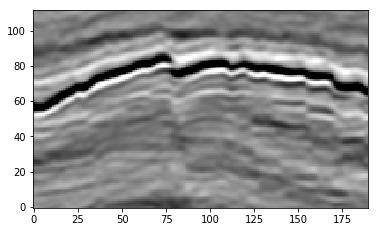

In [13]:
section_file = 'data/base_sections/inl244_base_formatted_region_(359.1400)(549.1848).csv'

my_data = np.genfromtxt(section_file, delimiter=' ')
plt.imshow(np.flipud(my_data), origin='lower', cmap="gray", vmin=-4500, vmax=4500)

scale_factor = 4
new_data = np.zeros(np.array(my_data.shape) * scale_factor)
for j in range(my_data.shape[0]):
    for k in range(my_data.shape[1]):
        new_data[j * scale_factor: (j+1) * scale_factor, k * scale_factor: (k+1) * scale_factor] = my_data[j, k]

im.imsave('section.png', new_data, cmap="gray")

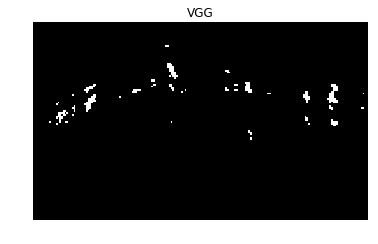

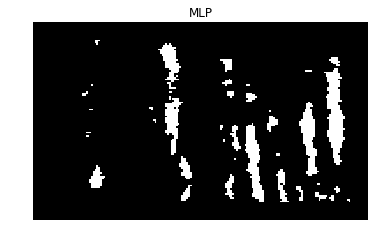

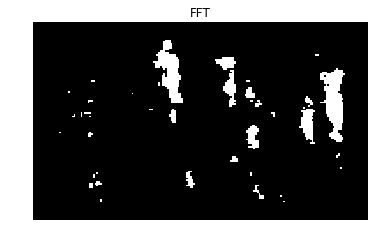

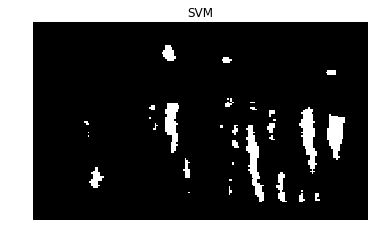

In [14]:
classification_files = {}
classification_files['VGG'] = 'output/classification/classification_VGG_inl244.txt'
classification_files['MLP'] = 'output/classification/classification_MLP_inl244.txt'
classification_files['FFT'] = 'output/classification/classification_FFT_inl244.txt'
classification_files['SVM'] = 'output/classification/classification_SVM_inl244.txt'

for model, file in classification_files.items():
    mask = np.zeros(my_data.shape)
    classification = open(file, 'r')
    for line in classification:
        if int(line.split()[1]) == 1:
            patch = line.split()[0]
            x = int(patch.split("_")[2])
            y = int(patch.split("_")[3].split(".")[0])
            mask[x,y] = 1

    plt.figure()
    plt.title(model)
    plt.axis('off')
    plt.imshow(np.flipud(mask), origin='lower', cmap="gray")

    # resize data to save in bigger resolution
    new_data = np.zeros(np.array(mask.shape) * scale_factor)
    for j in range(mask.shape[0]):
        for k in range(mask.shape[1]):
            new_data[j * scale_factor: (j+1) * scale_factor, k * scale_factor: (k+1) * scale_factor] = mask[j, k]

    im.imsave('mask'+model+'.png', new_data, cmap="gray")

## Extract lines from mask

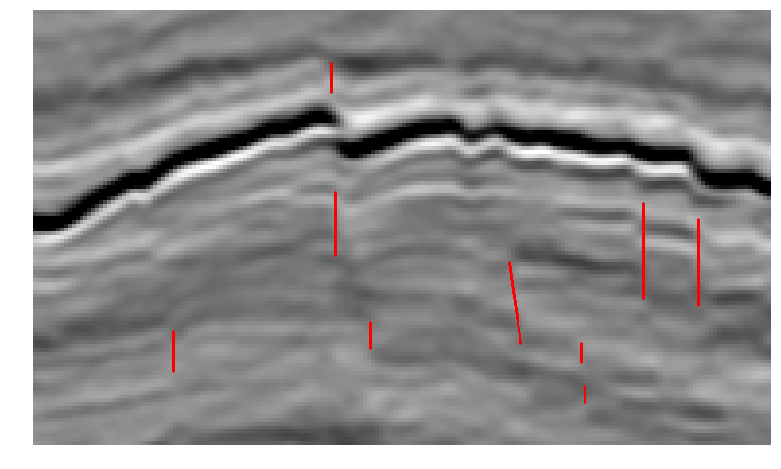

In [17]:
# get colormap
ncolors = 256
color_array = plt.get_cmap('gray')(range(ncolors))
color_array[255] = [1., 0., 0., 1.]
# change alpha values
color_array[:,-1] = np.linspace(0.0,1.0,ncolors)

# create a colormap object
map_object = LinearSegmentedColormap.from_list(name='line',colors=color_array)

# register this new colormap with matplotlib
plt.register_cmap(cmap=map_object)


classifiedImage  = imageio.imread('maskSVM.png', as_gray=True)
originalImage =  imageio.imread('section.png', as_gray=True)
plt.figure(figsize=(15,8))
plt.axis('off')
plt.imshow(np.flipud(originalImage), origin='lower', cmap="gray")

dilatedImage = morphology.binary_closing(classifiedImage, morphology.disk(5))

dilatedImage = morphology.binary_dilation(classifiedImage, morphology.disk(5))

dilatedImage = morphology.binary_erosion(classifiedImage, morphology.disk(3))
# plt.figure()
# plt.axis('off')
# plt.imshow(classifiedImage, cmap="gray")

# Get Connected Components
labels = measure.label(dilatedImage, background=0)
props = []

# Remove small components
max_area = 100
for region in measure.regionprops(labels):
    if region.area < max_area:
        continue
    
    props.append(region)

# Print original image to print lines over it
#figure, imshow(originalImage), hold on

for compIdx in range(len(props)):
    dilatedComponent = np.zeros(dilatedImage.shape)
    coords = tuple((props[compIdx].coords.T))
    dilatedComponent[coords] = 1
    dilatedComponentCV = np.array(dilatedComponent, dtype = np.uint8)
    dilatedComponent = np.zeros(dilatedImage.shape)

    minLineLength = 1
    maxLineGap = 15
    lines = cv2.HoughLinesP(dilatedComponentCV,0.1,np.pi/1800,0,minLineLength,maxLineGap)

    max_len = 0
    long = ()
    for line in lines:
        for x1,y1,x2,y2 in line:
            a = (x1,y1)
            b = (x2,y2)
            dist = np.linalg.norm(np.array(a)- np.array(b))
            if (dist > max_len):
                max_len = dist;
                long = (a,b)
                
    cv2.line(dilatedComponent,long[0],long[1],1,2)
    plt.imshow(np.flipud(dilatedComponent), origin='lower', cmap="line")